In [1]:
import numpy as np
import pandas as pd
import seaborn as sns # libreria utile per matrice di confusione
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, confusion_matrix, precision_recall_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from imblearn.over_sampling import RandomOverSampler

In [2]:
# leggo il dataset ed il target

dataset = pd.read_csv(r'C:\Users\andre\Desktop\materiale tesi\settimana 16\dataset\cleaned-\dataset-.csv', header = 0)
features_names = list(dataset.columns) # ottengo i nomi delle features
features_names.pop(0) # rimuovo il primo addresses, in quanto non e' una feature
pairs_number_features = list() # creo una lista che contiene coppie <#_feature, nome_feature>
idx = 0

while idx < len(features_names):
    pair = (idx, features_names[idx])
    pairs_number_features.append(pair)
    idx+=1
    
print(pairs_number_features)

target = pd.read_csv(r'C:\Users\andre\Desktop\materiale tesi\settimana 16\dataset\cleaned-\target.csv', header = 0)

[(0, 'balance'), (1, 'lifetime'), (2, 'tx_in'), (3, 'investment_to_contract/tx_in'), (4, 'payment_from_contract/tx_out'), (5, '#addresses_paying_contract'), (6, '#addresses_paid_by_contract'), (7, 'mean_v1'), (8, 'sdev_v1'), (9, 'sdev_v2'), (10, 'paid_rate'), (11, 'paid_one'), (12, 'percentage_some_tx_in'), (13, 'sdev_tx_in'), (14, 'percentage_some_tx_out'), (15, 'known_rate'), (16, 'owner_gets_eth_Wo_investing')]


In [3]:
X = dataset.values[:, 1:] # rimuovo la prima colonna che contiene gli indirizzi
y = target.values

# divido in train set (TR) e test set (TS)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42, stratify=y) 

from collections import Counter

y_train_list = [item for sublist in y_train.tolist() for item in sublist]
print("Before Random oversampling :" , Counter(y_train_list))

Before Random oversampling : Counter({0: 3107, 1: 538})


In [16]:
ros = RandomOverSampler(sampling_strategy='minority', random_state = 21)
X_train_rnd, y_train_rnd = ros.fit_resample(X_train, y_train)
print("After Random oversampling :" , Counter(y_train_rnd))

After Random oversampling : Counter({0: 3107, 1: 3107})


In [34]:
param_dist_DT = {
            'criterion' : ['entropy', 'gini'],
            'max_depth' : [6, 7, 8, 9],
            'min_samples_split' : [20, 25, 30]
}

In [35]:
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid=param_dist_DT, cv=3, n_jobs=8)

grid_dt.fit(X_train_rnd,y_train_rnd)
y_pred_train = grid_dt.predict(X_train_rnd) # effettuo la predizione su train set
print('best hyperparameters:: ', grid_dt.best_params_) # stampo i migliori iperparametri
print('best score:: ', grid_dt.best_score_) # media degli score (basata sulla metrica di scoring) date sulle cross validation
print('recall score on TR:: ', recall_score(y_train_rnd, y_pred_train))
print('precision score on TR:: ', precision_score(y_train_rnd, y_pred_train))

best hyperparameters::  {'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 20}
best score::  0.8416479613365176
recall score on TR::  0.8876729964596073
precision score on TR::  0.8475722188076213


In [36]:
clf_dt = DecisionTreeClassifier(**grid_dt.best_params_)
clf_dt.fit(X_train_rnd, y_train_rnd)
print('accuracy score on TR:: ', clf_dt.score(X_train_rnd, y_train_rnd))
print('accuracy score on TS:: ', clf_dt.score(X_test, y_test))

accuracy score on TR::  0.8640167364016736
accuracy score on TS::  0.7993421052631579


In [61]:
param_dist_RF = {
            'n_estimators':[180, 190, 200, 210],
            'criterion':['entropy', 'gini'],
            'max_depth' : [9],
            'min_samples_split' : [35, 40],
            'bootstrap': [True, False]
}

In [62]:
grid_rf = GridSearchCV(RandomForestClassifier(), param_grid=param_dist_RF, cv=3, n_jobs=8)

grid_rf.fit(X_train_rnd,y_train_rnd)
y_pred_train = grid_rf.predict(X_train_rnd) # effettuo la predizione su train set
print('best hyperparameters:: ', grid_rf.best_params_) # stampo i migliori iperparametri
print('best score:: ', grid_rf.best_score_) # media degli score (basata sulla metrica di scoring) date sulle cross validation
print('recall score on TR:: ', recall_score(y_train_rnd, y_pred_train))
print('precision score on TR:: ', precision_score(y_train_rnd, y_pred_train))

best hyperparameters::  {'bootstrap': False, 'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 35, 'n_estimators': 180}
best score::  0.8675583391904009
recall score on TR::  0.895397489539749
precision score on TR::  0.888250319284802


In [63]:
clf_rf = RandomForestClassifier(**grid_dt.best_params_)
clf_rf.fit(X_train_rnd, y_train_rnd)
print('accuracy score on TR:: ', clf_rf.score(X_train_rnd, y_train_rnd))
print('accuracy score on TS:: ', clf_rf.score(X_test, y_test))

accuracy score on TR::  0.8854200193112327
accuracy score on TS::  0.8355263157894737


In [71]:
grid_param_XGB = {
                'learning_rate' : [0.05],
                'n_estimators' : [300, 325, 350],
                'max_depth': [8,9],
                'colsample_bytree' : [0.8],
                'subsample' : [0.8],
                'reg_lambda' : [150]
}

In [72]:
grid_xgb = GridSearchCV(xgb.XGBClassifier(use_label_encoder=False, eval_metric='aucpr'), param_grid=grid_param_XGB, cv=3, n_jobs=8)

grid_xgb.fit(X_train_rnd,y_train_rnd)
y_pred_train = grid_xgb.predict(X_train_rnd) # effettuo la predizione su train set
print('best hyperparameters:: ', grid_xgb.best_params_) # stampo i migliori iperparametri
print('best score:: ', grid_xgb.best_score_) # media degli score (basata sulla metrica di scoring) date sulle cross validation
print('recall score on TR:: ', recall_score(y_train_rnd, y_pred_train))
print('precision score on TR:: ', precision_score(y_train_rnd, y_pred_train))

best hyperparameters::  {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 9, 'n_estimators': 350, 'reg_lambda': 150, 'subsample': 0.8}
best score::  0.8656271381404167
recall score on TR::  0.8841326037978757
precision score on TR::  0.9190364670458347


In [73]:
clf_xgb = xgb.XGBClassifier(learning_rate = 0.05, max_depth = 9, n_estimators = 350, reg_lambda = 150, 
                            subsample = 0.8, colsample_bytree = 0.8, use_label_encoder = False, eval_metric='aucpr')
clf_xgb.fit(X_train_rnd, y_train_rnd)
print('accuracy score on TR:: ', clf_xgb.score(X_train_rnd, y_train_rnd))
print('accuracy score on TS:: ', clf_xgb.score(X_test, y_test))

accuracy score on TR::  0.9031219826198905
accuracy score on TS::  0.8530701754385965


In [75]:
model_params = {
    'decision_tree': {
        'model': DecisionTreeClassifier(),
        'params': { 
            'criterion' : ['entropy', 'gini'],
            'max_depth' : [6, 7, 8, 9],
            'min_samples_split' : [20, 25, 30]
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators':[180, 190, 200, 210],
            'criterion':['entropy', 'gini'],
            'max_depth' : [8, 9],
            'min_samples_split' : [35, 40],
            'bootstrap': [True, False]
        }
    },
    'xgboost': {
        'model': xgb.XGBClassifier(learning_rate = 0.05, # funziona bene per valori fra 0.01 e 0.25
                                   subsample= 0.8,
                                   colsample_bytree = 0.8,
                                   eval_metric = 'aucpr', 
                                   use_label_encoder = False),
        'params': {
                'n_estimators' : [300, 325, 350],
                'max_depth': [8,9],
                'reg_lambda' : [150]
        }
    }
}

In [76]:

scores = []

for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=3, return_train_score=False, n_jobs=8)
    clf.fit(X_train_rnd, y_train_rnd.ravel())
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_,
        'best_estimator': clf.best_estimator_ # necessario per riallenare
    })
    
pd.set_option("display.max_colwidth", None)
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,decision_tree,0.842934,"{'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 20}"
1,random_forest,0.866110,"{'bootstrap': False, 'criterion': 'gini', 'max_depth': 9, 'min_samples_split': 35, 'n_estimators': 210}"
2,xgboost,0.865627,"{'max_depth': 9, 'n_estimators': 350, 'reg_lambda': 150}"


In [77]:
models_list = sorted(scores, key=lambda d: d['best_score']) # ordino in base al best_score
model = models_list[-1] # prendo l'ultimo modello (quello con score piu' alto)
clf = model.get('best_estimator') # ottengo i valori con cui allenare
clf.fit(X_train_rnd, y_train_rnd) # rialleno

RandomForestClassifier(bootstrap=False, max_depth=9, min_samples_split=35,
                       n_estimators=210)

                    (Number, Feature)  Importance
0                          (2, tx_in)    0.123287
1   (3, investment_to_contract/tx_in)    0.111927
2                      (11, paid_one)    0.104434
3                    (15, known_rate)    0.091708
4                    (13, sdev_tx_in)    0.080751
5         (12, percentage_some_tx_in)    0.066668
6                        (7, mean_v1)    0.061639
7                        (9, sdev_v2)    0.060011
8                     (10, paid_rate)    0.056042
9                       (1, lifetime)    0.052204
10   (6, #addresses_paid_by_contract)    0.047137
11    (5, #addresses_paying_contract)    0.046663
12                       (8, sdev_v1)    0.031600
13       (14, percentage_some_tx_out)    0.019931
14                       (0, balance)    0.019030
15  (4, payment_from_contract/tx_out)    0.017975
16  (16, owner_gets_eth_Wo_investing)    0.008993


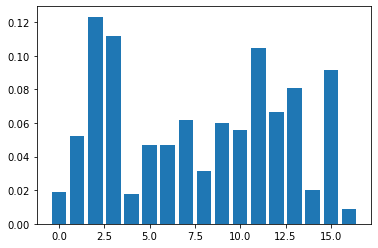

In [78]:
features_importances = clf.feature_importances_
res = dict(zip(pairs_number_features, features_importances))
sorted_dict = dict(sorted(res.items(), key=lambda item: item[1], reverse = True))
print(pd.DataFrame(list(sorted_dict.items()),columns=['(Number, Feature)', 'Importance']))
plt.bar(range(len(features_importances)), features_importances)
plt.show()

precision score::  0.45933014354066987
recall score::  0.7111111111111111
accuracy score::  0.8333333333333334
fbeta score::  0.6084836665041443
F1 score:: 0.5581395348837209


<AxesSubplot:>

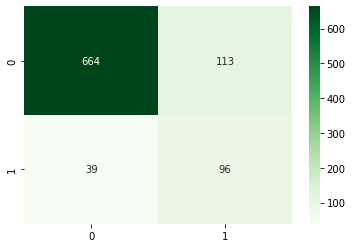

In [79]:
# faccio la predizione e stampo le statistiche sul modello migliore (quello che ha vinto nella GridSearch)

y_pred = clf.predict(X_test)
#print(clf.predict_proba(X_test)) # per vedere le probabilita' con cui sono classificati come ponzi o non ponzi
print('precision score:: ', precision_score(y_test, y_pred)) # TP / (FP + TP)
print('recall score:: ', recall_score(y_test, y_pred))	     # TP / (FN + TP)
print('accuracy score:: ', accuracy_score(y_test, y_pred))	 # (TP + TN)/ (TP + FN + TN + FP)
print('fbeta score:: ', fbeta_score(y_test, y_pred, beta = 1.5))
print('F1 score::', f1_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, cmap='Greens', fmt='d')

precision score::  0.5027322404371585
recall score::  0.6814814814814815
accuracy score::  0.8530701754385965
F1 score:: 0.578616352201258


<AxesSubplot:>

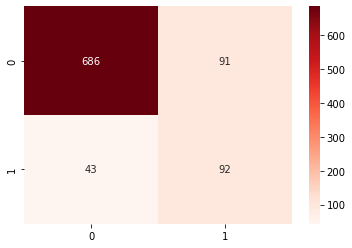

In [80]:
# risultati ottenuti con il secondo migliore

model = models_list[1] # prendo il modello medio
clf2 = model.get('best_estimator') # ottengo i valori con cui allenare
clf2.fit(X_train_rnd, y_train_rnd.ravel()) # rialleno
y_pred2 = clf2.predict(X_test)
#print(clf2.predict_proba(X_test)) # per vedere le probabilita' con cui sono classificati come ponzi o non ponzi
print('precision score:: ', precision_score(y_test, y_pred2)) #  TP / (FP + TP)
print('recall score:: ', recall_score(y_test, y_pred2))	     # 	TP / (FN + TP)
print('accuracy score:: ', accuracy_score(y_test, y_pred2))	 #  (TP + TN)/ (TP + FN + TN + FP)
print('F1 score::', f1_score(y_test, y_pred2))
cm = confusion_matrix(y_test, y_pred2)
sns.heatmap(cm, annot=True, cmap='Reds', fmt='d')